In [11]:
import warnings
warnings.filterwarnings("ignore")

# Import libraries

In [12]:
import geopandas as gpd
import pysal as ps
import psycopg2
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import mapclassify as mc
import seaborn as sns
import sklearn as sk
import shapely
%matplotlib inline

# Import data 
### shapefiles (census & roads)

In [ ]:
# a database named EV was created in postgresql. 
# PostGIS extension was created for the database. 
# shapefiles were added to the database using QGIS.
# Census and Road network shapefiles were downloaded from: www12.statcan.gc.ca


In [13]:
#creates a connection with postgresql  
con=psycopg2.connect(host="localhost",database="EV", user="postgres", password="****")

In [ ]:
'''# a shapefile can also be imported using GeoPandas
census=gpd.read_file('testcensus.shp')
census=census.to_crs(epsg=4326)'''

In [14]:
# four columns are imported from the table census_table  
sql1= 'SELECT cduid, cdname , prname, ST_Transform(geom,4326) AS geom FROM census_table'
census=gpd.GeoDataFrame.from_postgis(sql1,con, geom_col='geom')

In [15]:
census.head()

,cduid,cdname,prname,geom
0,4706,Division No. 6,Saskatchewan,"MULTIPOLYGON (((-105.59107 51.09563, -105.5898..."
1,4714,Division No. 14,Saskatchewan,"MULTIPOLYGON (((-103.62734 53.63867, -103.6282..."
2,4715,Division No. 15,Saskatchewan,"MULTIPOLYGON (((-105.10096 53.71477, -105.1010..."
3,4712,Division No. 12,Saskatchewan,"MULTIPOLYGON (((-108.35932 52.85164, -108.3559..."
4,4713,Division No. 13,Saskatchewan,"MULTIPOLYGON (((-109.73322 53.02796, -109.7324..."


In [16]:
sql2="SELECT ST_Transform(geom, 4326) AS geom , prname_l, rank FROM road_network_table WHERE rank IN ('1','2')" 
highway=gpd.GeoDataFrame.from_postgis(sql2,con, geom_col='geom')

#the shapefile contained all roads, streets, alleys, etc... . Only major highways indicated by ranks 1 and 2 
#were imported.

In [17]:
highway.head()

,geom,prname_l,rank
0,"MULTILINESTRING ((-130.34492 54.29442, -130.34...",British Columbia / Colombie-Britannique,2
1,"MULTILINESTRING ((-113.53094 53.58060, -113.53...",Alberta,1
2,"MULTILINESTRING ((-73.62417 45.39798, -73.6242...",Quebec / Québec,2
3,"MULTILINESTRING ((-113.57793 53.51205, -113.57...",Alberta,2
4,"MULTILINESTRING ((-64.37439 45.91021, -64.3743...",New Brunswick / Nouveau-Brunswick,1


### EV stations

In [18]:
# downloaded from: https://developer.nrel.gov/api/alt-fuel-stations
df=pd.read_csv('fuel_stations.csv')

In [19]:
station=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df['Longitude'], y=df['Latitude']), crs='EPSG:4326')

In [20]:
cols=['State','geometry']
station=station[cols]

In [21]:
station.drop(station[station.geometry.x>0].index,axis=0, inplace=True)
#station['geometry'].dropna(inplace=True)
station.drop(index=station[station['geometry'].x.isna()].index, inplace=True, axis=0)

In [22]:
station.head()

,State,geometry
0,AB,POINT (-111.89861 50.58524)
1,AB,POINT (-113.99828 51.28812)
2,AB,POINT (-113.49069 53.42135)
3,AB,POINT (-113.50725 53.51770)
4,AB,POINT (-114.04303 51.09286)


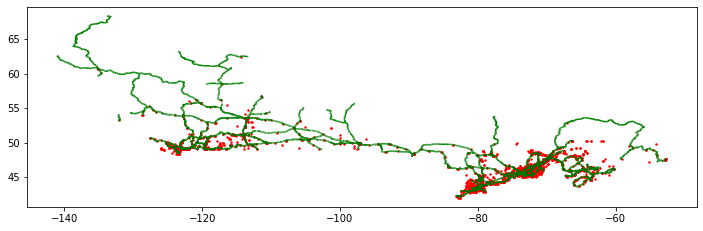

In [38]:
# plots the data to make sure they are imported properly
fig, axes=plt.subplots(figsize=(12,12))
#census.boundary.plot( ax=axes)
station.plot(ax=axes, markersize=2, color='red')
highway.plot(ax=axes, color='green')

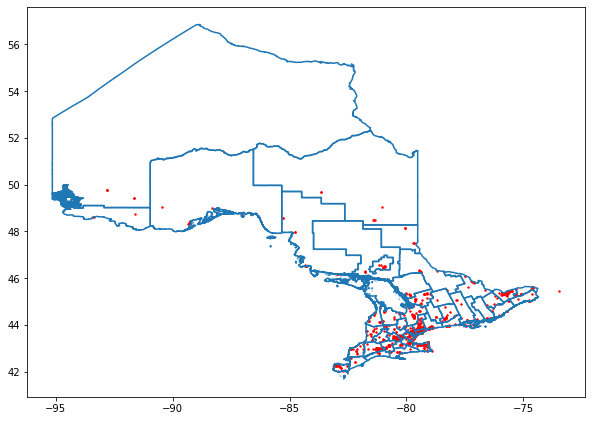

In [39]:
#plots the stations located in Ontario
fig, axes=plt.subplots(figsize=(10,10))
census[census['prname']=='Ontario'].boundary.plot( ax=axes)
station[station['State']=='ON'].plot(ax=axes, markersize=2, color='red')

### population data

In [43]:
#csv file was downloaded from https://www.statcan.gc.ca
df_pop=pd.read_csv('population_2016.csv',encoding = "ISO-8859-1")

In [44]:
df_pop=df_pop[(df_pop['DIM: Profile of Census Divisions (2247)']=='Population, 2016')]

In [45]:
df_pop_cols=['GEO_CODE (POR)',
       'Dim: Sex (3): Member ID: [1]: Total - Sex']
df_pop=df_pop[df_pop_cols]

In [46]:
df_pop.rename(columns={'GEO_CODE (POR)':'cduid', 'Dim: Sex (3): Member ID: [1]: Total - Sex':'population'}, inplace=True)

In [47]:
df_pop.head(2)

,cduid,population
0,1001,270348
2247,1002,20372


### income data

In [49]:
#csv file was downloaded from https://www.statcan.gc.ca
df_income=pd.read_csv('income_2016.csv',encoding = "ISO-8859-1")

In [50]:
df_income=df_income[df_income['Household type']=='Total \x96 Household type including census family structure']

In [51]:
df_income_cols=['Geographic code', 'Median household total income (2015 constant dollars), 2015']
df_income=df_income[df_income_cols]

In [52]:
df_income.rename(columns={'Median household total income (2015 constant dollars), 2015':'income',
                         'Geographic code':'cduid'}, inplace=True)

In [117]:
df_income.head()

,cduid,income
0,1001,74676
9,1002,60912
18,1003,56224
27,1004,44282
36,1005,62565


In [53]:
df_pop['cduid']=df_pop['cduid'].astype('str')
df_income['cduid']=df_income['cduid'].astype('str')

## find the number of EV stations for each census id

In [54]:
#counts the number of EV stations for each census using spatial join on census id field
df_count=gpd.sjoin(census[census['prname']=='Ontario'],station[station['State']=='ON'],
                 op='contains').dissolve(by='cduid',aggfunc='count')[['cdname']]

df_count.rename(columns={'cdname':'count'}, inplace=True)

## creating a GeoDataFrame by merging spatial/non-spatial data

In [55]:
dfs=[census,df_income, df_pop, df_count]

gdf = reduce(lambda left,right: pd.merge(left,right,on=['cduid']), dfs)

In [56]:
gdf.head()

,cduid,cdname,prname,geom,income,population,count
0,3501,"Stormont, Dundas and Glengarry",Ontario,"MULTIPOLYGON (((-74.47130 45.40187, -74.47002 ...",59526,113429,9
1,3502,Prescott and Russell,Ontario,"MULTIPOLYGON (((-74.62539 45.63443, -74.62378 ...",78748,89333,18
2,3506,Ottawa,Ontario,"MULTIPOLYGON (((-75.32508 45.50888, -75.32426 ...",85981,934243,98
3,3507,Leeds and Grenville,Ontario,"MULTIPOLYGON (((-75.61306 45.10545, -75.61303 ...",68305,100546,16
4,3509,Lanark,Ontario,"MULTIPOLYGON (((-76.21583 45.30193, -76.21445 ...",71660,68698,6


# plotting the data

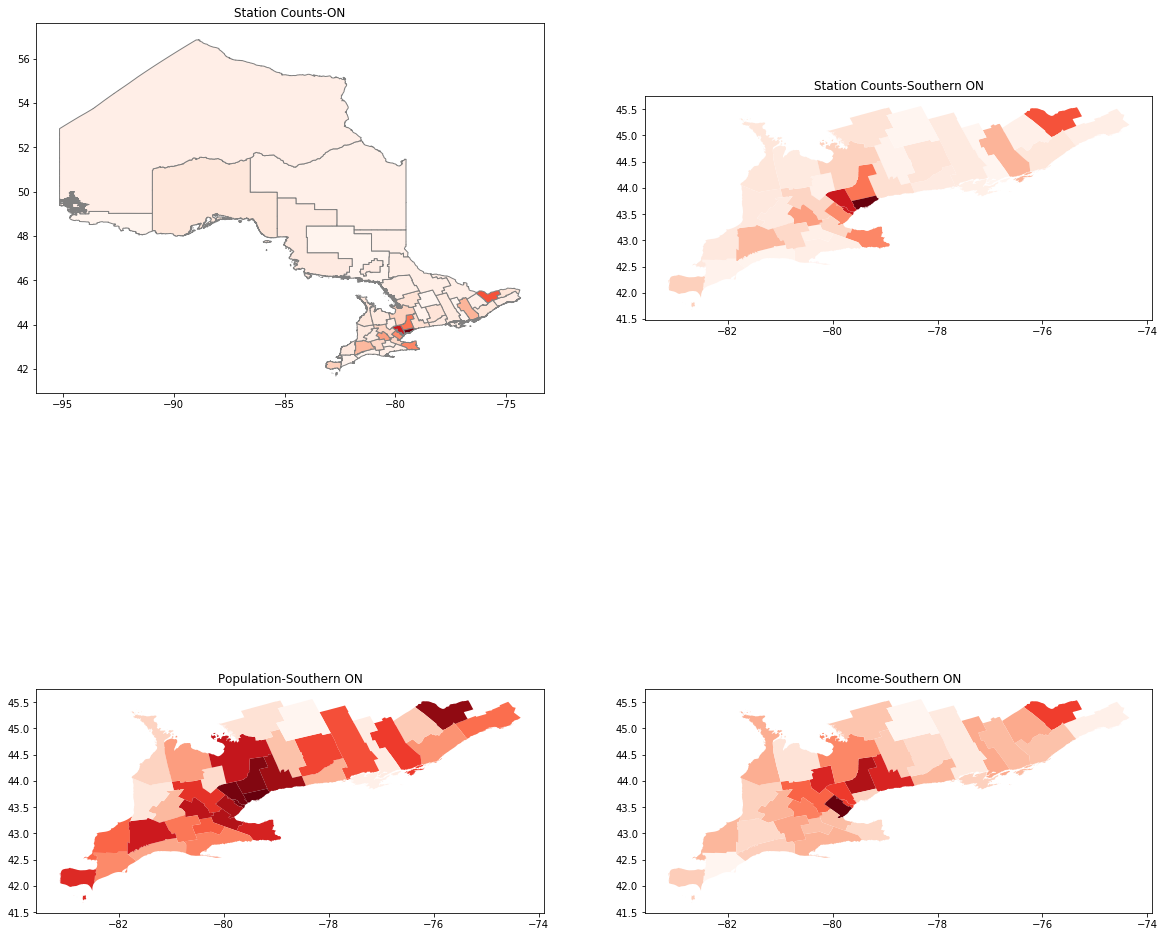

In [128]:
fig, axes= plt.subplots(2,2, figsize=(20,20))

axes[0,0].set_title('Station Counts-ON')
gdf.plot(column='count',cmap='Reds', figsize=(10,10), edgecolor='gray', ax=axes[0,0])


axes[0,1].set_title('Station Counts-Southern ON')
gdf.cx[:,:45].plot(column='count', cmap='Reds', ax=axes[0,1])

axes[1,0].set_title('Population-Southern ON')
gdf.cx[:,:45].plot(column='population', cmap='Reds', ax=axes[1,0])

axes[1,1].set_title('Income-Southern ON')
gdf.cx[:,:45].plot(column='income', cmap='Reds', ax=axes[1,1])




# spatial data analysis

In [61]:
#calculates queen contigutiy weight
qw=ps.weights.Queen.from_dataframe(gdf, geom_col='geom', idVariable='cduid') #to have names of polygons as id

In [62]:
qw.transform='r' #it is the required format to calculate spatial lag

In [64]:
gdf['spatial_lag']=ps.weights.lag_spatial(qw,gdf['count'])# calculates spatial lag for each census

In [65]:
lag5=mc.Quantiles(gdf['spatial_lag'], k=5) # color mapper

In [114]:
lag5.yb

array([4, 4, 1, 3, 4, 0, 2, 0, 2, 1, 2, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 3,
       2, 3, 2, 2, 3, 0, 2, 1, 3, 2, 2, 3, 1, 1, 3, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1])

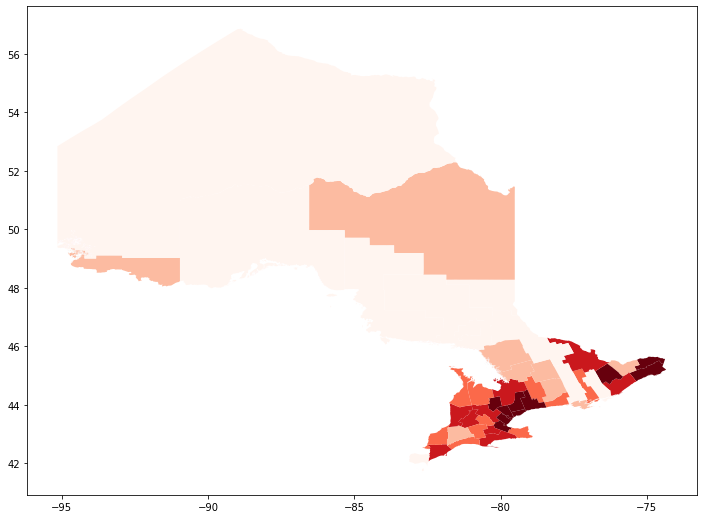

In [115]:
gdf.assign(cl=lag5.yb).plot(column='cl',cmap='Reds', figsize=(12,12))

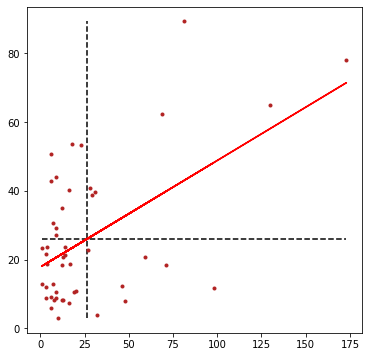

In [67]:
#Moran plot
b, a = np.polyfit(gdf['count'], gdf['spatial_lag'], 1)
f, ax = plt.subplots(1, figsize=(6, 6))

plt.plot(gdf['count'], gdf['spatial_lag'], '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(gdf['count'].mean(), gdf['spatial_lag'].min(), gdf['spatial_lag'].max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(gdf['spatial_lag'].mean(), gdf['count'].min(), gdf['count'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(gdf['count'], a + b*gdf['count'], 'r')

In [72]:
I=ps.Moran(gdf['count'], qw)

In [73]:
I.I, I.p_sim

(0.31004303435099545, 0.005)

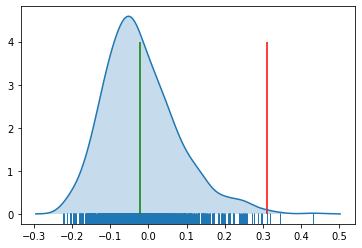

In [74]:
sns.kdeplot(I.sim, shade=True)
sns.rugplot(I.sim)
#plt.vlines(I.sim, 0, 0.5)
plt.vlines(I.I,0, 4, 'r')
plt.vlines(I.EI,0, 4, 'green')

In [77]:
MoranL=ps.Moran_Local(gdf['count'], qw)

In [78]:
sig= (MoranL.p_sim<0.05)
sig.sum()

9

In [79]:
Hotspots=MoranL.q==1 * sig
Hotspots.sum()

3

In [80]:
coldspots=MoranL.q==3 * sig
coldspots.sum()

5

In [81]:
gdf[Hotspots]

,cduid,cdname,prname,geom,income,population,count,spatial_lag
12,3519,York,Ontario,"MULTIPOLYGON (((-79.25061 44.45319, -79.25070 ...",95776,1.10991e+06,81,89.250000
13,3520,Toronto,Ontario,"MULTIPOLYGON (((-79.15202 43.81439, -79.15191 ...",65829,2.73157e+06,173,78.000000
14,3521,Peel,Ontario,"MULTIPOLYGON (((-79.70463 43.86366, -79.70338 ...",86233,1.38174e+06,130,64.833333


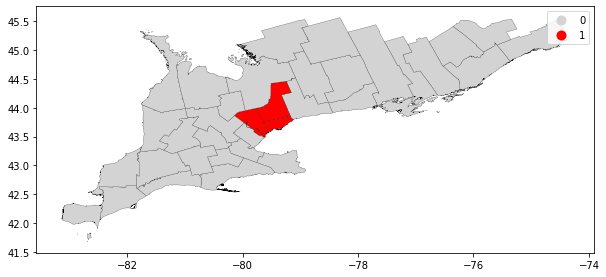

In [82]:
hmap=colors.ListedColormap(['lightgrey','red'])
gdf.assign(cl=Hotspots*1).cx[:,:45].plot(column='cl', cmap=hmap, categorical=True, legend=True, figsize=(10,10),
                                            edgecolor='black', linewidth=0.2) # interesting use of *1 and assign to have 0/1 not True False
#categorical=True for having legend 0 1 not continous 

In [111]:
#list of coldspot census
gdf[coldspots]

,cduid,cdname,prname,geom,income,population,count,spatial_lag,KM4Cluster
7,3512,Hastings,Ontario,"MULTIPOLYGON (((-77.69017 45.43668, -77.68827 ...",61109,136445,13,8.285714,0
37,3548,Nipissing,Ontario,"MULTIPOLYGON (((-79.63039 47.16550, -79.63087 ...",60303,83150,9,8.714286,0
39,3552,Sudbury,Ontario,"MULTIPOLYGON (((-81.85630 48.13079, -81.85689 ...",65333,21546,3,8.666667,0
41,3554,Timiskaming,Ontario,"MULTIPOLYGON (((-79.51761 48.25894, -79.51759 ...",59360,32251,6,6.000000,0
44,3558,Thunder Bay,Ontario,"MULTIPOLYGON (((-86.54802 51.37667, -86.54807 ...",68062,146048,16,7.250000,0


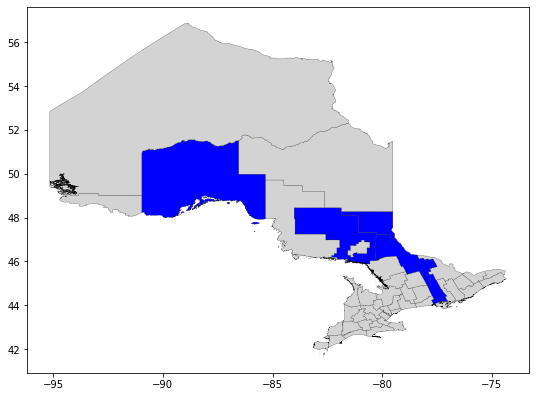

In [83]:
hmap=colors.ListedColormap(['lightgrey', 'blue'])
gdf.assign(cl=coldspots*1).plot(figsize=(9,9), column='cl', cmap=hmap, edgecolor='black', linewidth=0.2)

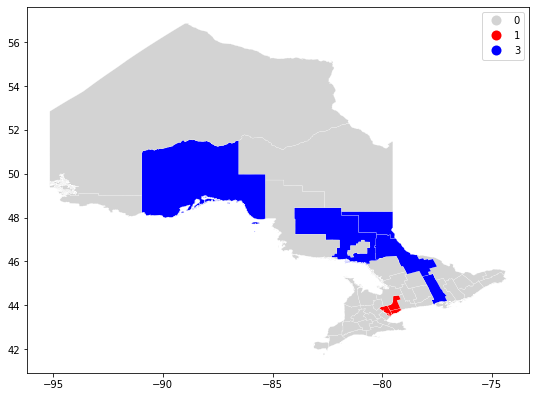

In [84]:
hmap=colors.ListedColormap(['lightgrey', 'red', 'blue'])
gdf.assign(cl=Hotspots*1+coldspots*3).plot(figsize=(9,9), column='cl', cmap=hmap, edgecolor='white', linewidth=0.2, 
                                               categorical=True, legend=True)

# spatial clustering

In [87]:
model=AgglomerativeClustering(linkage='ward', connectivity=qw.sparse,
                             n_clusters=4)
model.fit(scaler.fit_transform(gdf[['count', 'income','population']]))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 204 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=4, pooling_func='deprecated')

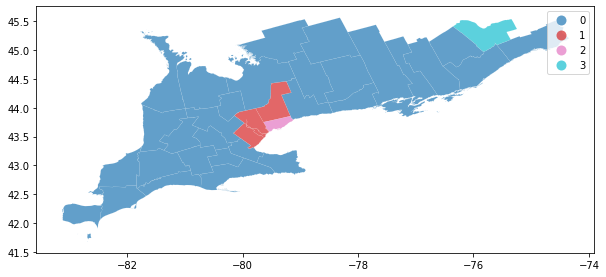

In [88]:
f, axes=plt.subplots(figsize=(10,10))
gdf.assign(cl=model.labels_).cx[:,:45].plot(column='cl', categorical=True, ax=axes, edgecolor='white', linewidth=0.1, 
                                        alpha=0.7, legend=True)

# data clustering

In [86]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
wcc=[]
scaler=StandardScaler()

for i in range (1,10):
    km=KMeans(n_clusters=i)
    km.fit(scaler.fit_transform(gdf[['count', 'income','population']]))
    wcc.append(km.inertia_)
    

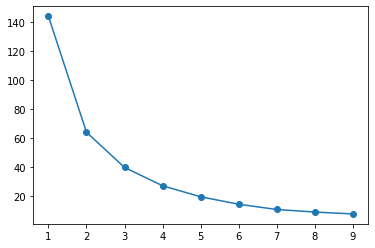

In [89]:
plt.plot(range(1,10), wcc, marker='o')

In [90]:
cluster=KMeans(n_clusters=4).fit_predict(scaler.fit_transform(gdf[['count', 'income','population']]))

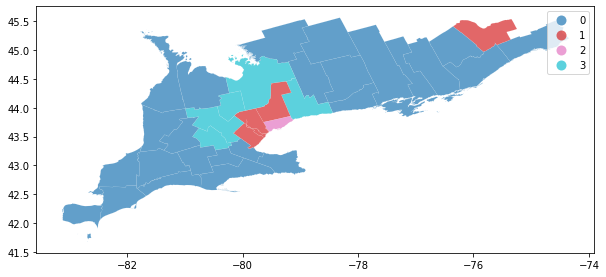

In [91]:
f, axes=plt.subplots(figsize=(10,10))
gdf.assign(cl=cluster).cx[:,:45].plot(column='cl', categorical=True, ax=axes, edgecolor='white', linewidth=0.1, 
                                        alpha=0.7, legend=True)

In [92]:
gdf['KM4Cluster']=cluster

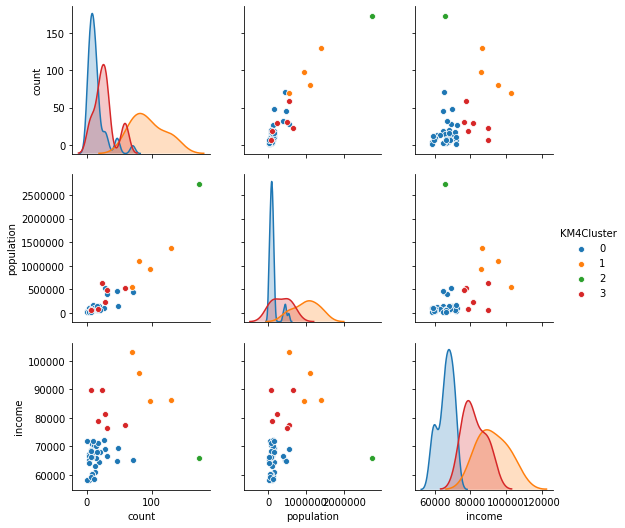

In [93]:
sns.pairplot(gdf, vars=['count','population','income'], hue='KM4Cluster')

## interactive plotting

In [94]:
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, HoverTool
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Category10
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tile_provider = get_provider(CARTODBPOSITRON)

In [95]:
gdf_mercator=gdf.to_crs(epsg=3857)

In [108]:
gdf_subset=gdf_mercator.iloc[:42]
merged_json = json.loads(gdf_subset.to_json())
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)

In [109]:
cl_map=CategoricalColorMapper(factors=['1', '2','0','3'], palette=Category10[4])
hover = HoverTool(tooltips = [ ('cdname','@cdname'),('count','@count'),('population','@population'),('income','@income')])

p = figure(title = 'Share',tools = [hover,"pan,wheel_zoom,box_zoom,reset"])

p.add_tile(tile_provider)

p.patches('xs','ys', source = geosource, 
           fill_color = {'field' :'KM4Cluster', 'transform' : cl_map}, alpha=0.9, line_color = 'white', line_width = 0.25)


GlyphRenderer(id='1489', ...)

In [1]:
output_notebook()#Display figure.
show(p)